In [1]:
import xarray as xr

In [2]:
import rioxarray

# Open the dataset with rioxarray (to preserve CRS)
ds = xr.open_dataset("germany_noise_dataset.nc", engine="netcdf4")

# Set CRS using rioxarray
for var in ds.data_vars:
    ds[var].rio.write_crs("EPSG:3035", inplace=True)

# Reproject each variable and stack them again
reprojected = xr.Dataset()
for var in ds.data_vars:
    print(f"Reprojecting {var}...")
    reprojected[var] = ds[var].rio.reproject("EPSG:4326")

# Rename dimensions and coordinates
reprojected = reprojected.rename({"x": "lon", "y": "lat"})
reprojected = reprojected.assign_coords(
    lon=reprojected.lon,
    lat=reprojected.lat
)

# 1. Remove the 'band' dimension by squeezing it out
reprojected = reprojected.squeeze("band", drop=True)

# 2. Drop the 'spatial_ref' coordinate
reprojected = reprojected.drop_vars("spatial_ref")



# Optional: Save to new file
reprojected.to_netcdf("germany_noise_latlon.nc")


Reprojecting road_lden...
Reprojecting road_lnight...
Reprojecting rail_lden...
Reprojecting rail_lnight...
Reprojecting air_lden...
Reprojecting air_lnight...
Reprojecting ind_lden...
Reprojecting ind_lnight...


In [8]:
arr = xr.open_dataset("germany_noise_latlon.nc")

In [11]:
bbox = [9.922567, 53.484453, 10.067449, 53.544880]
arr.sel(
    lon=slice(bbox[0], bbox[2]),
    lat=slice(bbox[1], bbox[3])
)["road_lden"].plot.contour()

TypeError: No numeric data to plot.

API tile shape:       (256, 256)
Stitched crop shape:  (420, 383)
❌ Shapes do not match. Comparison aborted.


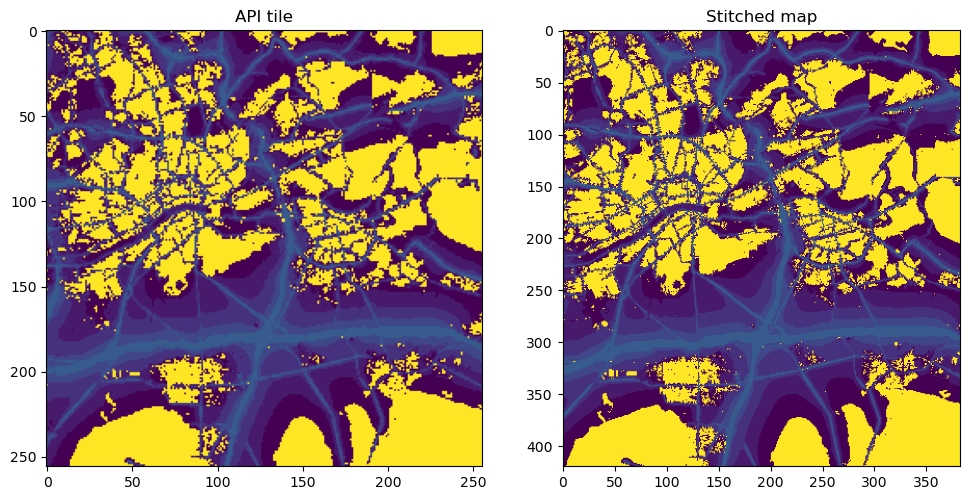

In [13]:
import requests
import numpy as np
import xarray as xr
import rasterio
from rasterio.io import MemoryFile
import matplotlib.pyplot as plt

# === Settings ===
API_URL = "https://noise.discomap.eea.europa.eu/arcgis/rest/services/noiseStoryMap/NoiseContours_road_lden/ImageServer/exportImage"
LAYER_NAME = "road_lden"
DATASET_PATH = "germany_noise_dataset.nc"

# Bounding box around Hamburg in EPSG:3035
bbox_3035 = [4222454.868061548, 2990658.049915443, 4237408.454756766, 3007084.486249549]
resolution = (256, 256)

# === Step 1: Fetch tile from API ===
params = {
    "bbox": ",".join(map(str, bbox_3035)),
    "bboxSR": "3035",
    "size": f"{resolution[1]},{resolution[0]}",
    "format": "tiff",
    "f": "image"
}

response = requests.get(API_URL, params=params)
response.raise_for_status()

with MemoryFile(response.content) as memfile:
    with memfile.open() as dataset:
        api_data = dataset.read(1)
        api_transform = dataset.transform

# === Step 2: Load stitched dataset ===
ds = xr.open_dataset(DATASET_PATH)
da = ds[LAYER_NAME]

# === Step 3: Convert bbox to index slices ===
x_min, y_min, x_max, y_max = bbox_3035
x_coords = da.x.values
y_coords = da.y.values

x0 = np.searchsorted(x_coords, x_min, side="left")
x1 = np.searchsorted(x_coords, x_max, side="right")
y0 = np.searchsorted(y_coords[::-1], y_max, side="left")
y1 = np.searchsorted(y_coords[::-1], y_min, side="right")
y0 = len(y_coords) - y0
y1 = len(y_coords) - y1

stitched_crop = np.squeeze(da.isel(x=slice(x0, x1), y=slice(y0, y1)).values)

# === Step 4: Compare ===
print(f"API tile shape:       {api_data.shape}")
print(f"Stitched crop shape:  {stitched_crop.shape}")

if api_data.shape == stitched_crop.shape:
    diff = np.abs(api_data - stitched_crop)
    print(f"Max difference: {diff.max()}")
    print(f"Mean difference: {diff.mean()}")
else:
    print("❌ Shapes do not match. Comparison aborted.")
    diff = None

# === Step 5: Visual inspection ===
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(api_data, cmap="viridis")
axs[0].set_title("API tile")
axs[1].imshow(np.squeeze(stitched_crop), cmap="viridis")
axs[1].set_title("Stitched map")
if diff is not None:
    axs[2].imshow(np.squeeze(diff), cmap="inferno")
    axs[2].set_title("Absolute Difference")
else:
    axs[2].set_visible(False)
plt.tight_layout()
plt.show()


In [12]:
x_min_stitched = float(ds.x.min())
x_max_stitched = float(ds.x.max())
y_min_stitched = float(ds.y.min())
y_max_stitched = float(ds.y.max())

print("Stitched map bounds (EPSG:3035):")
print(f"x: {x_min_stitched} to {x_max_stitched}")
print(f"y: {y_min_stitched} to {y_max_stitched}")


Stitched map bounds (EPSG:3035):
x: 4050019.53125 to 4749980.46875
y: 2800019.53125 to 3249980.46875
